As observed from the analytical solution, the parameters $b_t$ and $c_t$ are time dependent. To improve the functional approximation for the Q function using the Semi-Gradient SARSA algorithm, we attempted to train different Q functions for different step to see if there is any improvements.

In [1]:
from tqdm.notebook import tnrange
import numpy as np
from scipy.stats import bernoulli, norm
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### Base functions

In [2]:
def Utility_CARA(WT,a):
    return (1-np.exp(-a*WT))/a

def epsilon_fun(epsilon_0, epsilon_decay, t,epsilon_min = 0):
    return ((epsilon_0-epsilon_min)*np.exp(-epsilon_decay*t)+epsilon_min)

def RewardFunction(Wt,a,gamma):
    return -(np.exp(-a*Wt))/a

def theta_0(dim,T):
    return np.array(np.ones(dim*T).reshape((dim, T)))

def Yt(a,b,p,n=1):
    return bernoulli.rvs(size = n,p = p)*(a-b)+b

def Zt(mu,sigma,n = 1):
    return norm.rvs(size = n,loc = mu, scale = sigma)

def Allocation(Wt, epsilon, Q, theta,t, is_allocation_stochastic = True): #Action determined by the state
    #Epsilon Greedy
    choice = bernoulli.rvs(p = 1 - epsilon)
    if choice == 0:
        # print("explore")
        return np.random.uniform(high = Wt)
    else:
        # print("Greedy")
        x = np.linspace(start = 0, stop = Wt, num = 1000, endpoint = True)
        current_q = Q(Wt,x,theta,t)

        if is_allocation_stochastic:
            sample_n_actions = np.random.choice(current_q,300,replace = False)
            sample_index = [np.where(i == sample_n_actions)[0][0] for i in sample_n_actions]              # need refactor
          
            sample_max_q = np.argmax(sample_n_actions)
            sample_index_with_max = sample_index[sample_max_q]

            Optimal_Action = x[sample_index_with_max]
        else:
            max_q = np.argmax(current_q)
            Optimal_Action = x[max_q]

        return(Optimal_Action)

### Q function forms

In [3]:
def Q(Wt, xt, theta,t):
    n = len(xt)
    x = np.array([np.ones(n),np.ones(n)*Wt,xt])
    return np.matmul(theta[:,t],x)

def Qexp(Wt, xt, theta,t):
    return theta[0,t]*np.exp(theta[1,t]*Wt+theta[2,t]*xt)

def Qexp2(Wt, xt, theta,t):
    return theta[0,t]*np.exp(theta[1,t]*Wt+theta[2,t]*xt+theta[3,t]*(xt**2))

def Qexp3(Wt, xt, theta,t):
    return theta[0,t] + theta[1,t]*np.exp(theta[2,t]*Wt+theta[3,t]*xt+theta[4,t]*(xt**2))

def Qexp4(Wt, xt, theta,t):
    return theta[0,t] + theta[1,t]*np.exp(theta[2,t]*Wt+theta[3,t]*xt)
    
def Gradient_q(Wt,xt,theta,t):
    return np.array([1,Wt,xt[0]])

def Gradient_qexp(Wt,xt,theta,t):
    xt = xt[0]
    return(np.array([np.exp(theta[1,t]*Wt+theta[2,t]*xt),\
                     theta[0,t]*Wt*np.exp(theta[1,t]*Wt+theta[2,t]*xt),\
                     theta[0,t]*xt*np.exp(theta[1,t]*Wt+theta[2,t]*xt)\
                    ]))

def Gradient_qexp2(Wt,xt,theta,t):
    xt = xt[0]
    return(np.array([np.exp(theta[1,t]*Wt+theta[2,t]*xt+theta[3,t]*(xt**2)),\
                     theta[0,t]*Wt*np.exp(theta[1,t]*Wt+theta[2,t]*xt+theta[3,t]*(xt**2)),\
                     theta[0,t]*xt*np.exp(theta[1,t]*Wt+theta[2,t]*xt+theta[3,t]*(xt**2)),\
                     theta[0,t]*(xt**2)*np.exp(theta[1,t]*Wt+theta[2,t]*xt+theta[3,t]*(xt**2))
                    ]))

def Gradient_qexp3(Wt,xt,theta,t):
    xt = xt[0]
    return(np.array([1,
                     np.exp(theta[2,t]*Wt+theta[3,t]*xt+theta[4,t]*(xt**2)),\
                     theta[1,t]*Wt*np.exp(theta[2,t]*Wt+theta[3,t]*xt+theta[4,t]*(xt**2)),\
                     theta[1,t]*xt*np.exp(theta[2,t]*Wt+theta[3,t]*xt+theta[4,t]*(xt**2)),\
                     theta[1,t]*(xt**2)*np.exp(theta[2,t]*Wt+theta[3,t]*xt+theta[4,t]*(xt**2))
                    ]))

def Gradient_qexp4(Wt,xt,theta,t):
    xt = xt[0]
    return(np.array([1,
                     np.exp(theta[2,t]*Wt+theta[3,t]*xt),\
                     theta[1,t]*Wt*np.exp(theta[2,t]*Wt+theta[3,t]*xt),\
                     theta[1,t]*xt*np.exp(theta[2,t]*Wt+theta[3,t]*xt)
                    ]))
def Qexp5(Wt, xt, theta,t):
    return theta[0,t]*np.exp(theta[1,t]*Wt+theta[2,t]*xt) + theta[3,t]*np.exp(theta[4,t]*Wt+theta[5,t]*xt)

def Gradient_qexp5(Wt,xt,theta,t):
    xt = xt[0]
    return(np.array([np.exp(theta[1,t]*Wt+theta[2,t]*xt),\
                     theta[0,t]*Wt*np.exp(theta[1,t]*Wt+theta[2,t]*xt),\
                     theta[0,t]*xt*np.exp(theta[1,t]*Wt+theta[2,t]*xt),\
                     np.exp(theta[4,t]*Wt+theta[5,t]*xt),\
                     theta[3,t]*Wt*np.exp(theta[4,t]*Wt+theta[5,t]*xt),\
                     theta[3,t]*xt*np.exp(theta[4,t]*Wt+theta[5,t]*xt),\
                    ]))

def Qexp6(Wt, xt, theta,t):
    return theta[0,t] + theta[1,t]*np.exp(theta[2,t]*Wt+theta[3,t]*xt) + theta[4,t]*np.exp(theta[5,t]*Wt+theta[6,t]*xt)

def Gradient_qexp6(Wt,xt,theta,t):
    xt = xt[0]
    return(np.array([1,\
                     np.exp(theta[2,t]*Wt+theta[3,t]*xt),\
                     theta[1,t]*Wt*np.exp(theta[2,t]*Wt+theta[3,t]*xt),\
                     theta[1,t]*xt*np.exp(theta[2,t]*Wt+theta[3,t]*xt),\
                     np.exp(theta[5,t]*Wt+theta[6,t]*xt),\
                     theta[4,t]*Wt*np.exp(theta[5,t]*Wt+theta[6,t]*xt),\
                     theta[4,t]*xt*np.exp(theta[5,t]*Wt+theta[6,t]*xt),\
                    ]))


def Q_analytical(Wt, xt, theta,t):
    return theta[0,t]*np.exp(theta[1,t]*Wt)*(np.exp(theta[2,t]*xt) + np.exp(theta[3,t]*xt))

def Gradient_q_analytical(Wt,xt,theta,t):
    xt = xt[0]
    return(np.array([np.exp(theta[1,t]*Wt)*(np.exp(theta[2,t]*xt) + np.exp(theta[3,t]*xt)),\
                     theta[0,t]*theta[1,t]*np.exp(theta[1,t]*Wt)*(np.exp(theta[2,t]*xt) + np.exp(theta[3,t]*xt)),\
                     theta[0,t]*theta[2,t]*np.exp(theta[1,t]*Wt)*(np.exp(theta[2,t]*xt) + np.exp(theta[3,t]*xt)),\
                     theta[0,t]*theta[3,t]*np.exp(theta[1,t]*Wt)*(np.exp(theta[2,t]*xt) + np.exp(theta[3,t]*xt))
                    ]))

### Parameters

In [4]:
W_0 = 1
T = 10
alpha = 0.05 #learning rate in TD
gamma = 0.1 #Discount rate in TD
epsilon_0 = 1.0
epsilon_decay = 0.01
epsilon_min = 0.001
n = 100000
A = 0.08
B = 0.02
r = 0.03
p = 0.6
a: float = 1.0
mu = 0.05
sigma = 0.1

In [5]:
printstep = False

def trainSARSA(W_0,T,alpha,gamma,a,A,B,r,p,n,Q,Gradient_q,n_para,dist = "Bernoulli",decay = True,Stochastic = False):
    theta = theta_0(n_para,T) #Initialize parameter for Q_function
    final = []
    thetatemp = np.empty((n_para,0),float)
    xtemp = np.empty((T,0),float)
    for episode in tnrange(0,n):
        
        # print("Episode", i_)
        epsilon = epsilon_fun(epsilon_0,epsilon_decay,episode,epsilon_min) if decay else 0.05
        
        #Initial State S
        W_t = W_0 
        
        #Action State A
        xt = np.array([Allocation(W_t,epsilon,Q,theta,0,Stochastic)])
        x_epi_temp = xt
        # print("xt", xt) if printstep else None
        
        for step in range(0,T):
            #Take Action A
            Y_t = Yt(A,B,p) if dist== "Bernoulli" else Zt(mu,sigma)
            
            #Observe S'
            W_t1 = (xt*(1+Y_t)+(W_t-xt)*(1+r))[0]
            
            #Observe R
            R_t = RewardFunction(W_t1,a,gamma) if (step + 1) == T else 0
            # print("step:", step, "; W_t", W_t, "; Yt:", Y_t,"; x_t", xt, "; W_t1:", W_t1) if printstep else None
            # print("Before Update:", theta) if printstep else None
            if (step + 1) == T: # Terminal
                # print("R_t+1:", R_t) if printstep else None
                delta = (R_t - Q(W_t,xt,theta,step))*Gradient_q(W_t,xt,theta,step)
                theta[:,step] += alpha*delta
                break
            else:
                xt1 = np.array([Allocation(W_t1,epsilon,Q,theta,step,Stochastic)])
                delta = (R_t  + gamma*Q(W_t1,xt1,theta,step+1)- Q(W_t,xt,theta,step))[0]*Gradient_q(W_t,xt,theta,step)
                x_epi_temp = np.append(x_epi_temp,np.array([xt1]))
                theta[:,step] += alpha*delta
                        
            #S <- S'
            W_t = W_t1
            
            #A <- A'
            xt = xt1
            
        thetatemp = np.append(thetatemp,np.array([theta[:,step]]).transpose(),axis = 1)
        xtemp = np.append(xtemp,np.array([x_epi_temp]).transpose(),axis = 1)
        final.append(W_t1)
    
    return theta, [thetatemp, xtemp, final]

def plotTemp(temp,n_para,T):
    Util_plot = plt.plot(temp[2])
    plt.title("Final Wealth")
    plt.show()
    
    grid = plt.GridSpec(n_para,1,wspace=0,hspace=0.3)
    paras_fig = plt.figure(figsize=(10,n_para*3))
    for i in range(n_para):
        ax = paras_fig.add_subplot(grid[i,0])
        ax.plot(temp[0][i])
        ax.title.set_text("theta "+str(i))
    
    x_grid = plt.GridSpec(T,1,wspace=0,hspace=1)
    x_fig = plt.figure(figsize=(10,20))
    for i in range(T):
        bx = x_fig.add_subplot(x_grid[i,0])
        bx.plot(temp[1][i])
        bx.title.set_text("x "+str(i+1))


In [6]:
analytical_theta, temp_analytical = trainSARSA(W_0,T,alpha,gamma,a,A,B,r,p,n,Q_analytical,Gradient_q_analytical,4,"Bernoulli",decay = True)

  0%|          | 0/100000 [00:00<?, ?it/s]

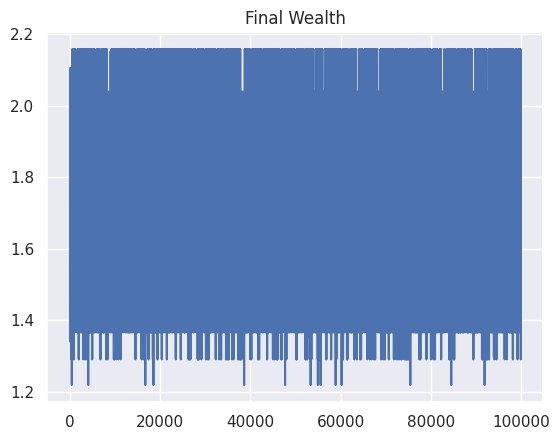

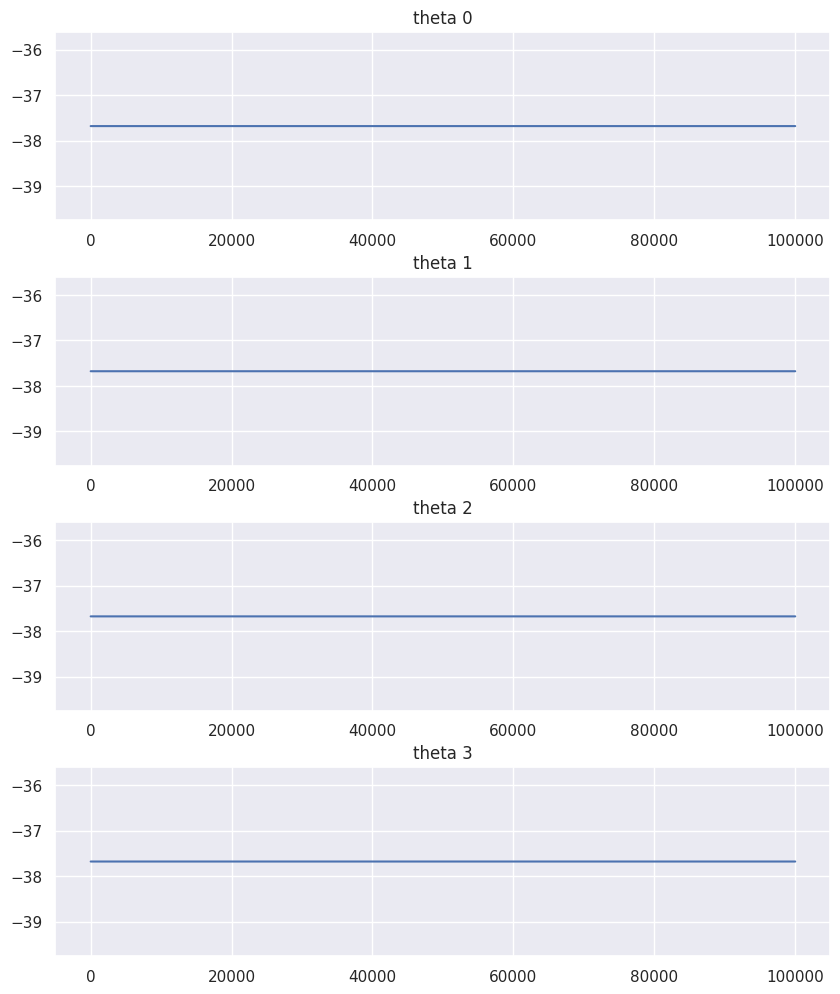

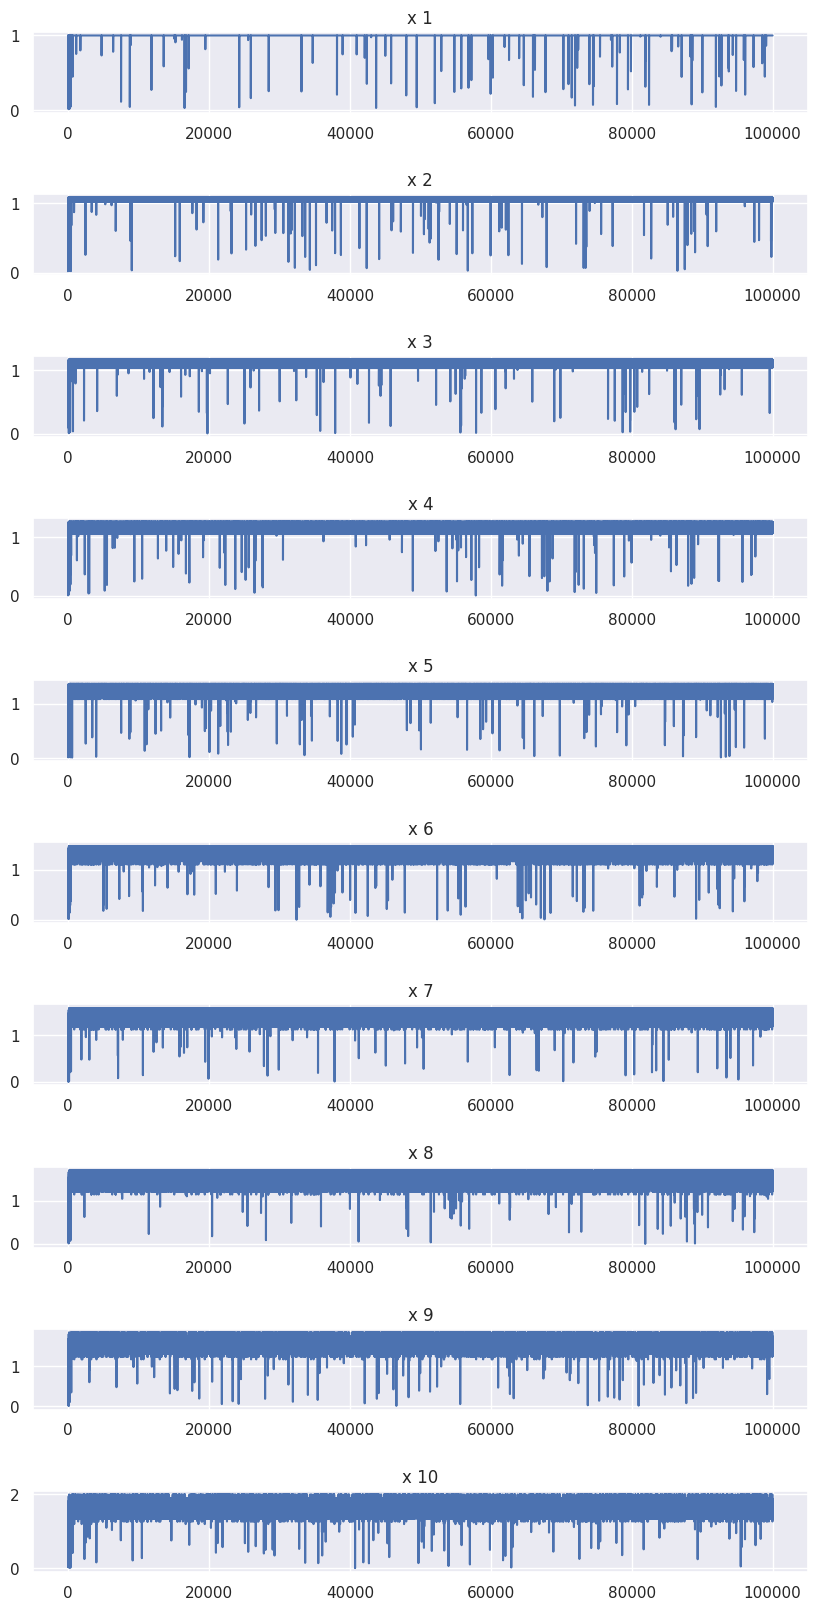

In [7]:
plotTemp(temp_analytical,4,T)

$$
Q^{Linear}_{t}(W_{t},x_{t}|\vec{\theta})=\theta_{0,t}+\theta_{1,t}W_{t}+\theta_{2,t}x_{t}\\
\nabla Q^{Linear}_{t}(W_{t},x_{t}) = (1, W_{t}, x_{t})
$$

In [8]:
theta, temp = trainSARSA(W_0,T,alpha,gamma,a,A,B,r,p,n,Q,Gradient_q,3,"Bernoulli",decay = True)

  0%|          | 0/100000 [00:00<?, ?it/s]

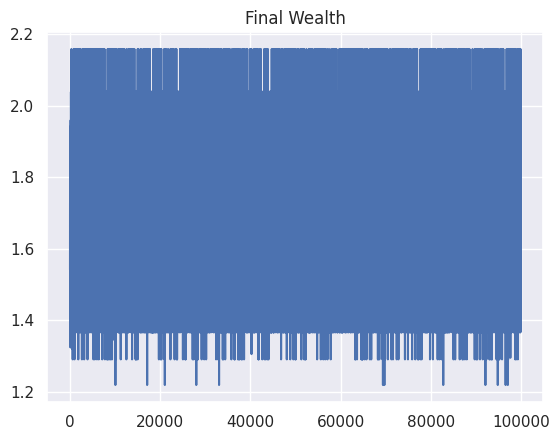

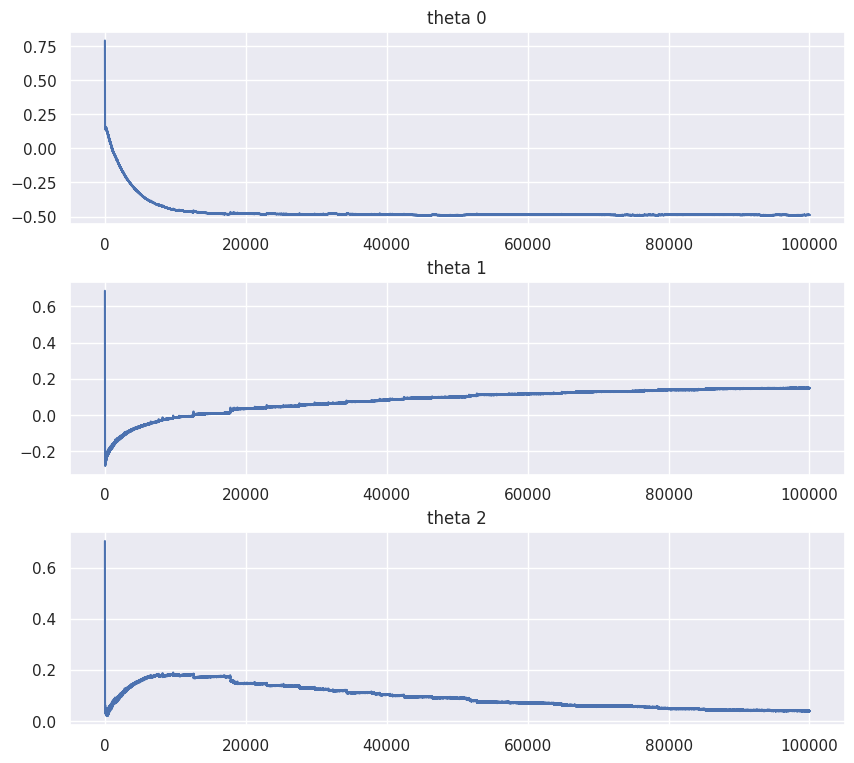

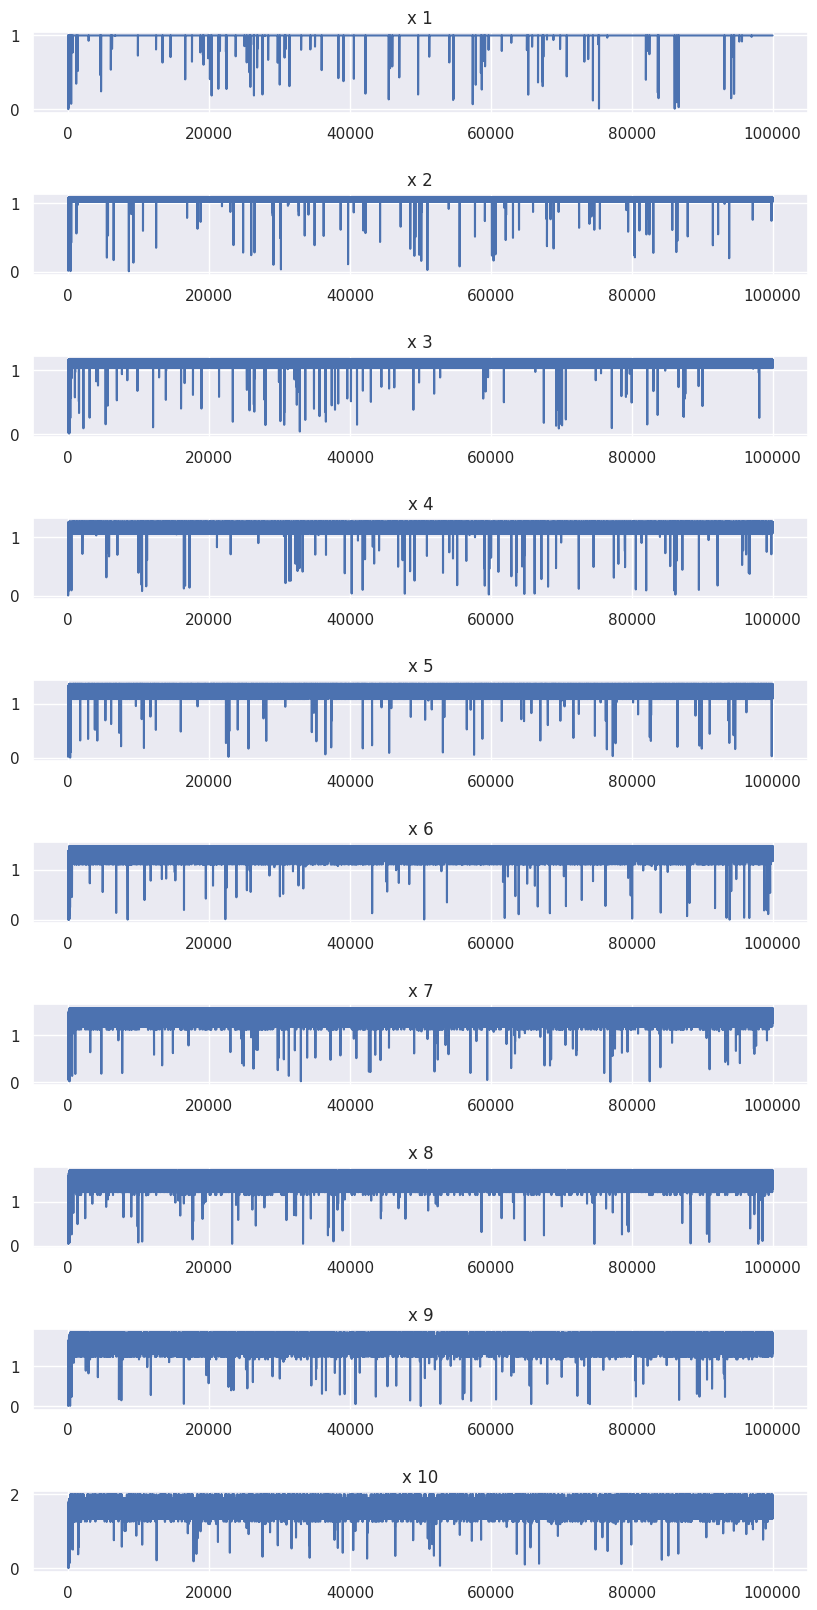

In [9]:
plotTemp(temp,3,T)

$$
Q_{t}(W_{t},x_{t}|\vec{\theta})=\theta_{0,t}e^{(\theta_{1,t}W_{t}+\theta_{2,t}x_{t})}
$$

In [10]:
thetaexp, tempexp = trainSARSA(W_0,T,alpha,gamma,a,A,B,r,p,n,Qexp,Gradient_qexp,3,"Bernoulli",decay = True)

  0%|          | 0/100000 [00:00<?, ?it/s]

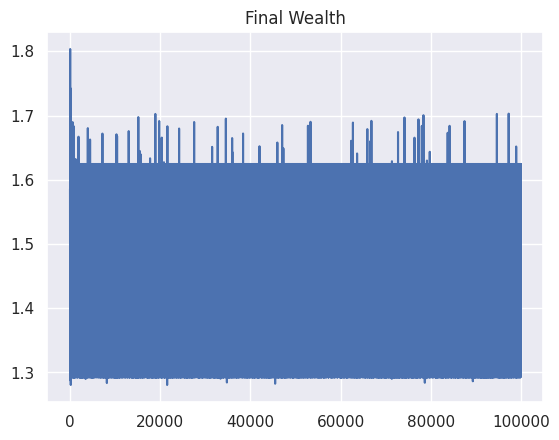

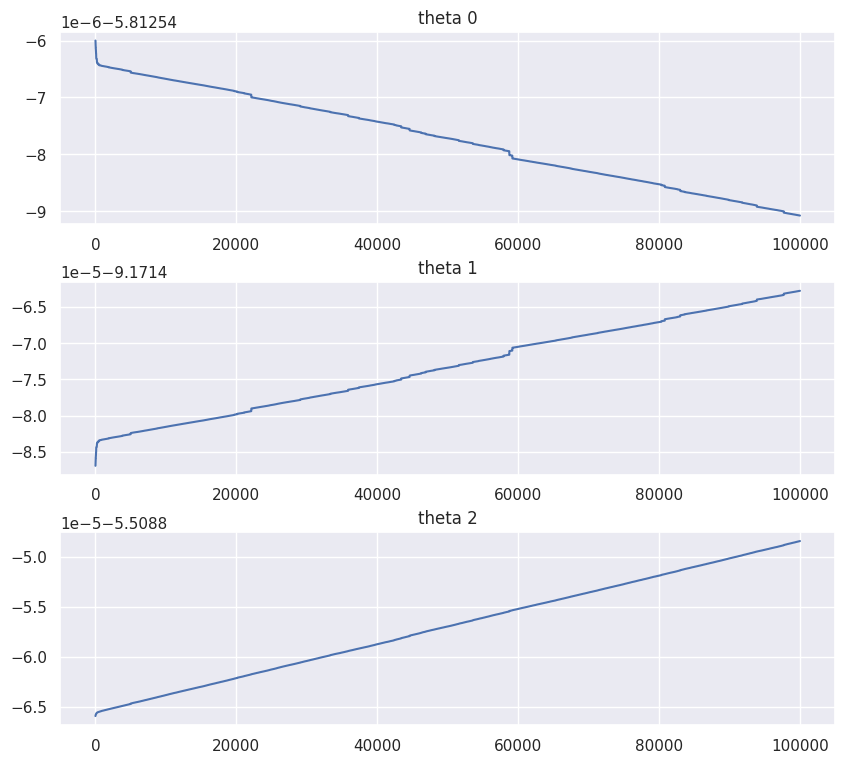

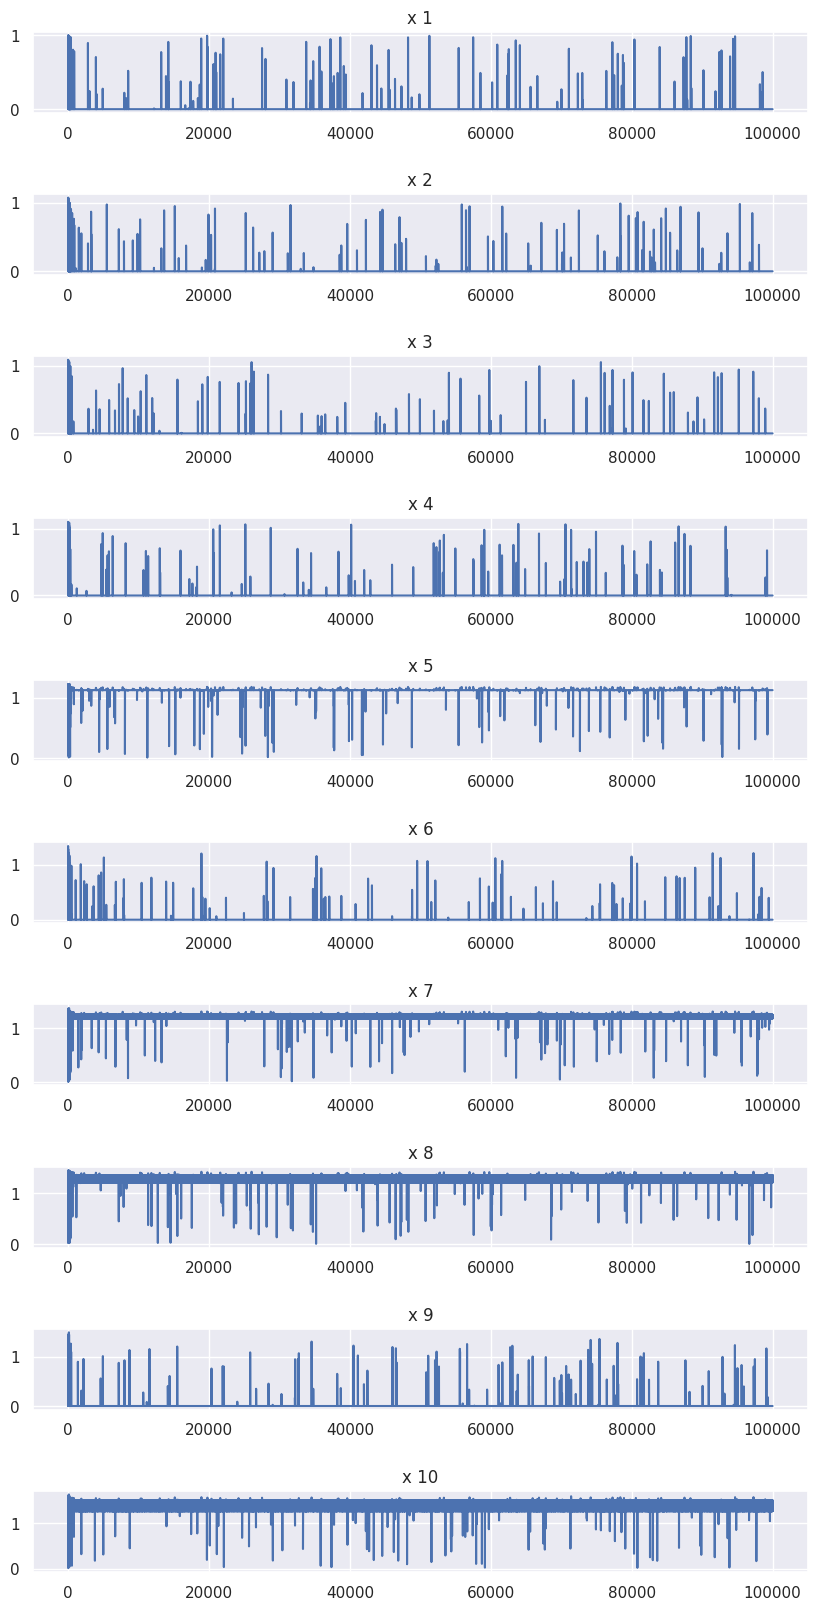

In [11]:
plotTemp(tempexp,3,T)

$$
Q_{t}^{2}(W_{t},x_{t}|\vec{\theta})=\theta_{0,t}e^{(\theta_{1,t}W_{t}+\theta_{2,t}x_{t}+\theta_{3,t}x_{t}^2)}
$$

In [12]:
thetaexp2, tempexp2 = trainSARSA(W_0,T,alpha,gamma,a,A,B,r,p,n,Qexp2,Gradient_qexp2,4,"Bernoulli",decay = True)

  0%|          | 0/100000 [00:00<?, ?it/s]

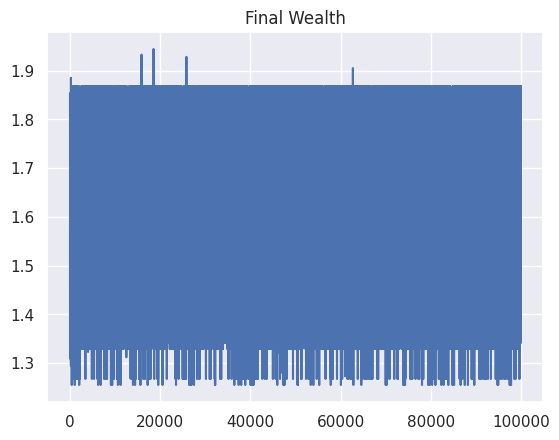

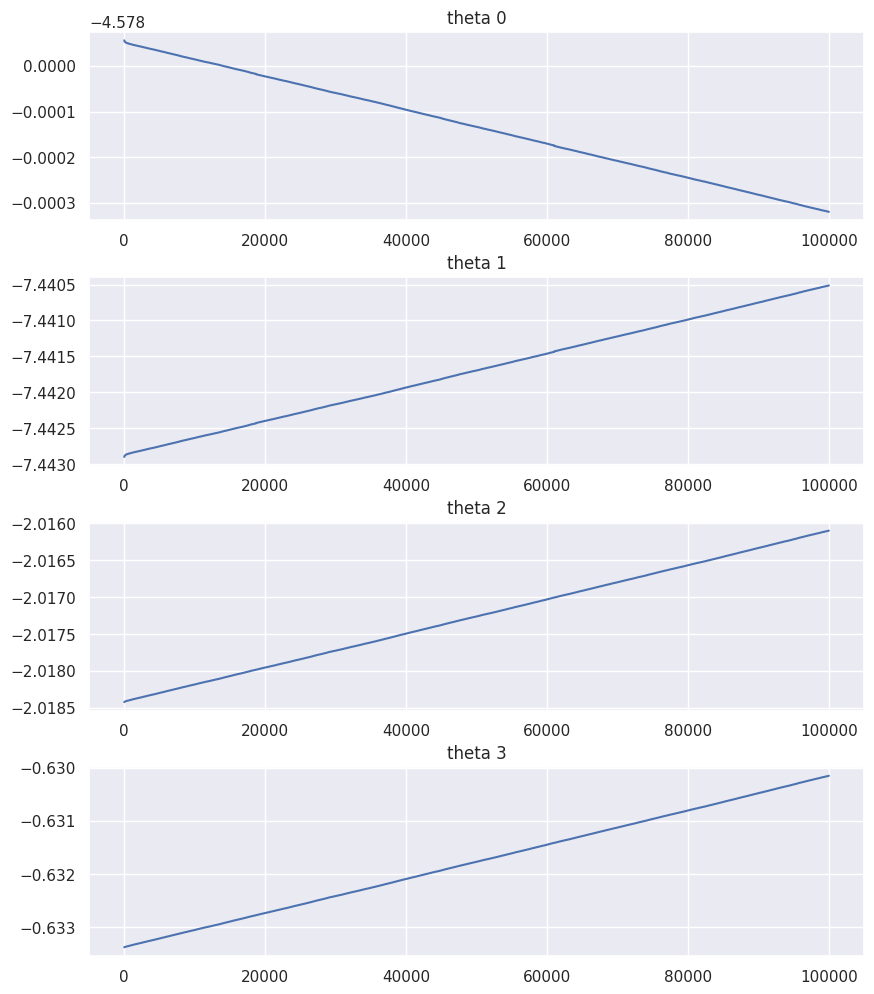

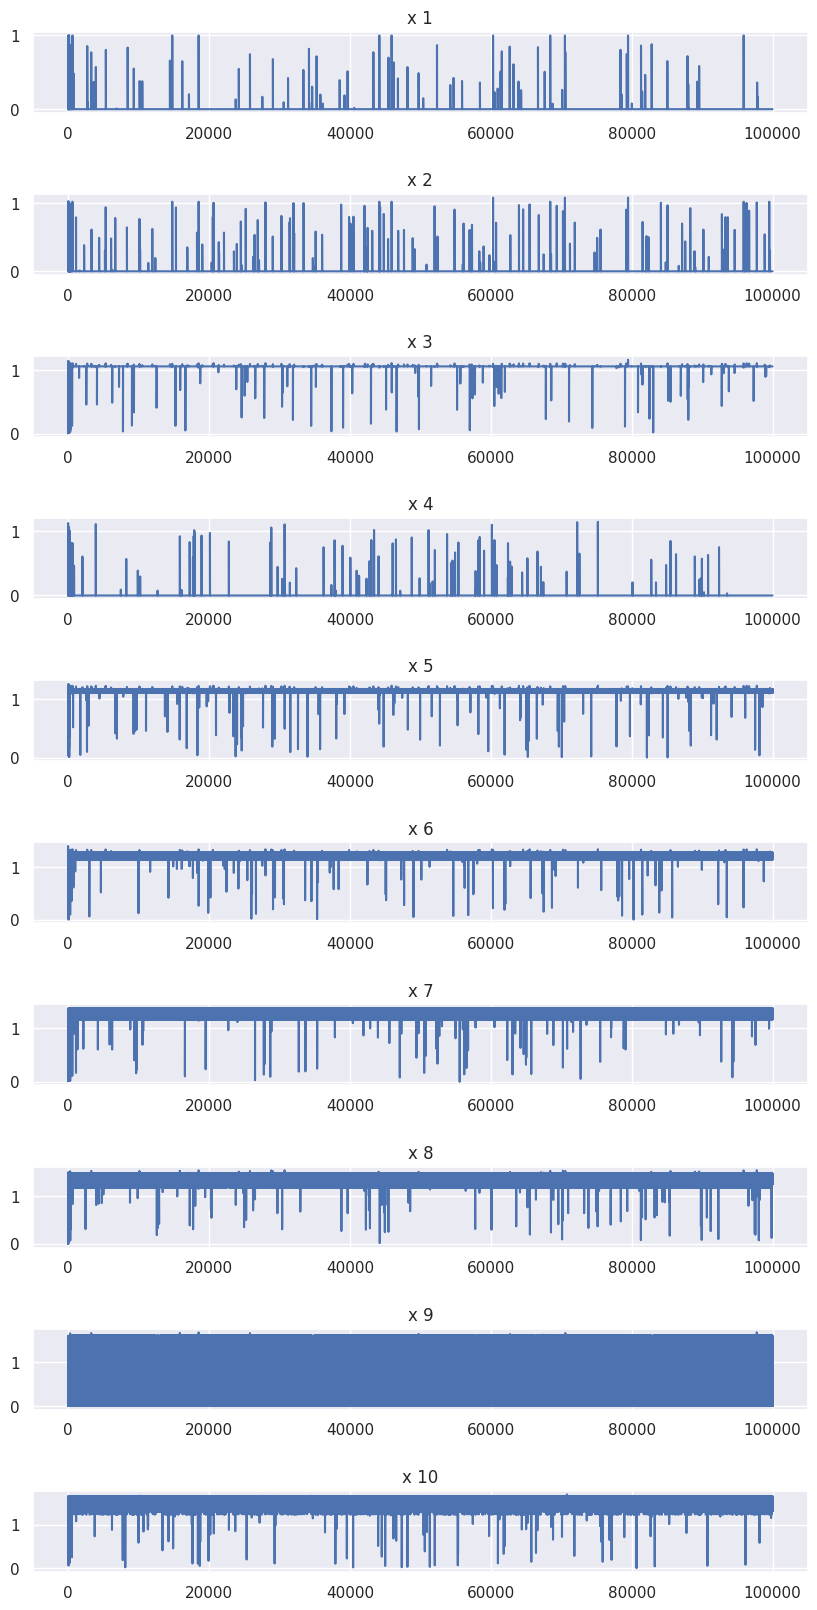

In [13]:
plotTemp(tempexp2,4,T)

$$
Q_{t}^{3}(W_{t},x_{t}|\vec{\theta})=\theta_{0,t}+\theta_{1,t}e^{(\theta_{2,t}W_{t}+\theta_{3,t}x_{t}+\theta_{4,t}x_{t}^2)}
$$

In [14]:
thetaexp3,temp3 = trainSARSA(W_0,T,alpha,gamma,a,A,B,r,p,n,Qexp3,Gradient_qexp3,5,"Bernoulli",decay = True)

  0%|          | 0/100000 [00:00<?, ?it/s]

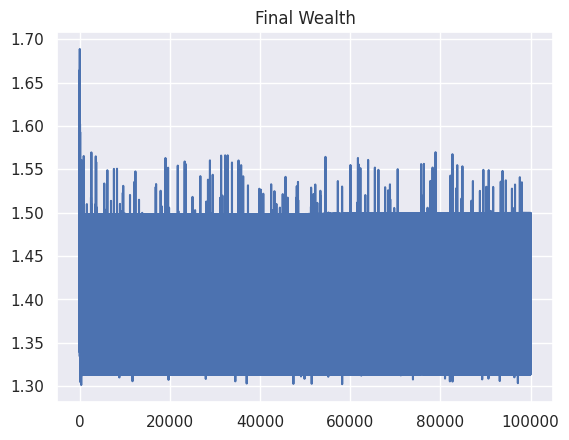

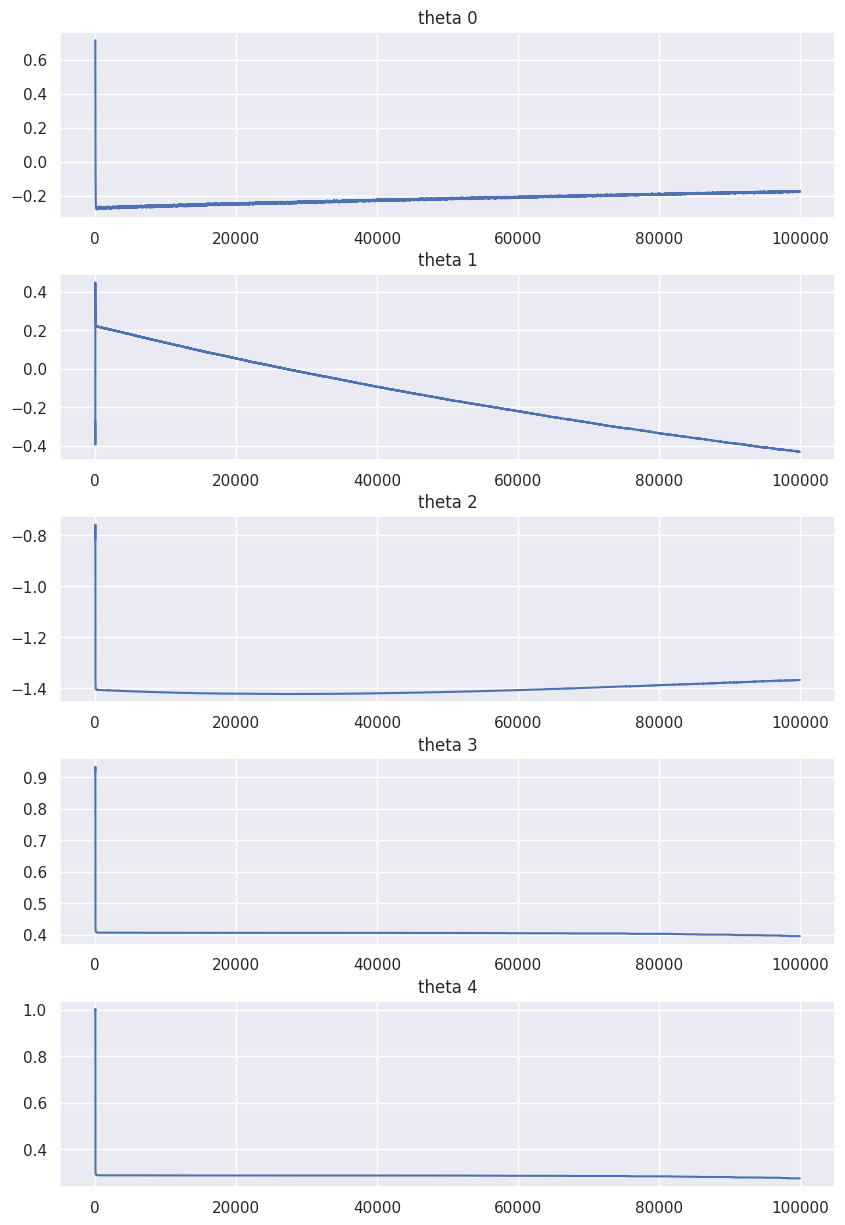

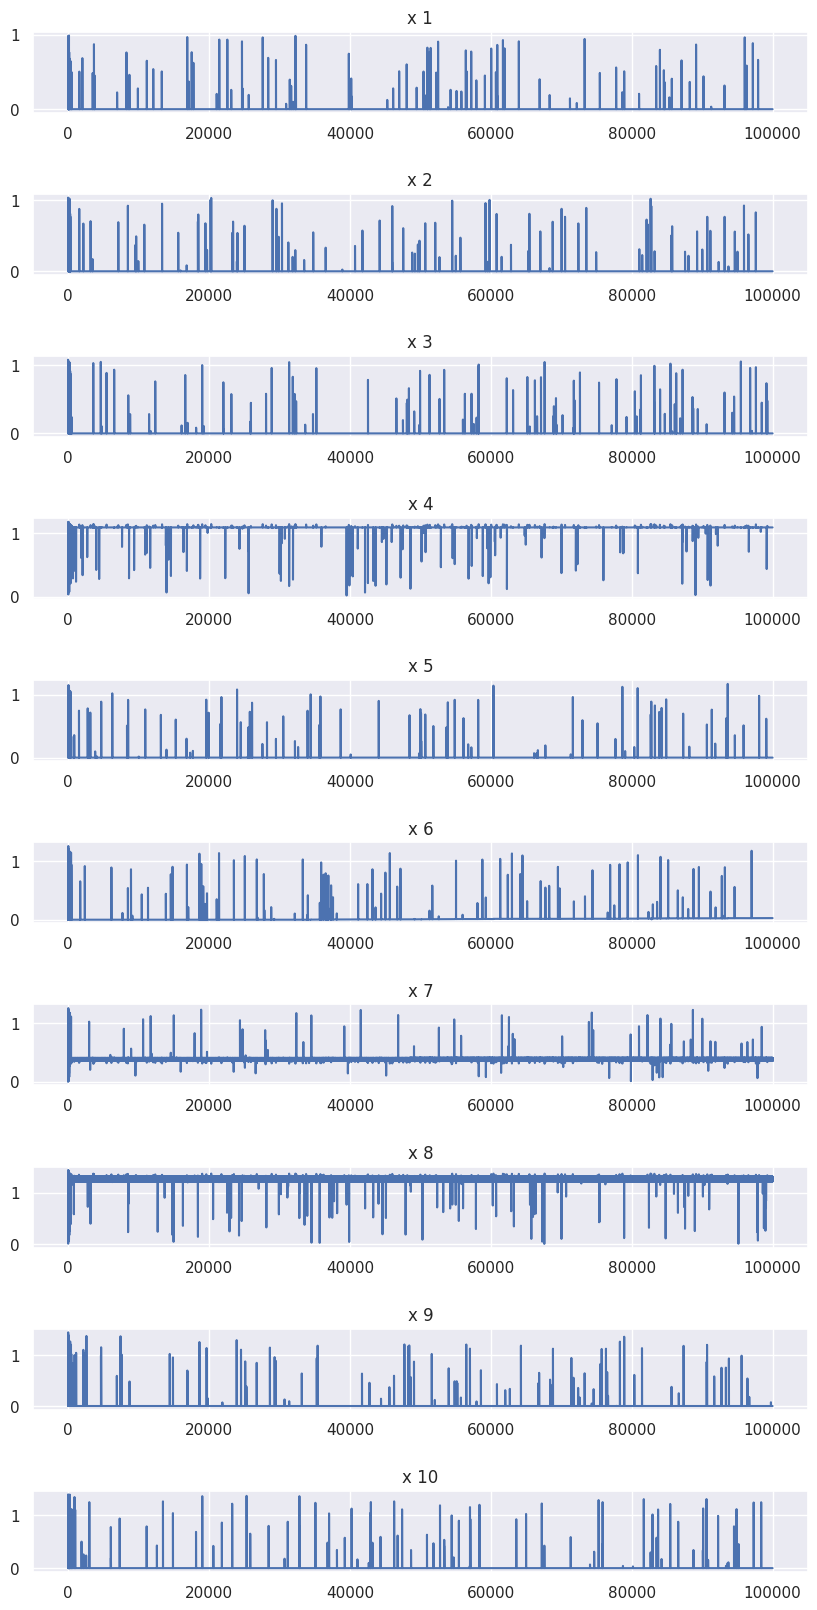

In [15]:
plotTemp(temp3,5,T)

$$
Q_{t}^{4}(W_{t},x_{t}|\vec{\theta_{t}})=\theta_{0,t}+\theta_{1,t}e^{(\theta_{2,t}W_{t}+\theta_{3,t}x_{t})}
$$

In [16]:
thetaexp4, temp4 = trainSARSA(W_0,T,alpha,gamma,a,A,B,r,p,n,Qexp4,Gradient_qexp4,4,"Bernoulli",decay = True)

  0%|          | 0/100000 [00:00<?, ?it/s]

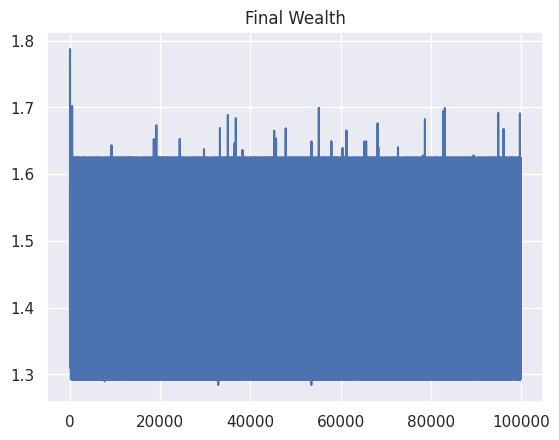

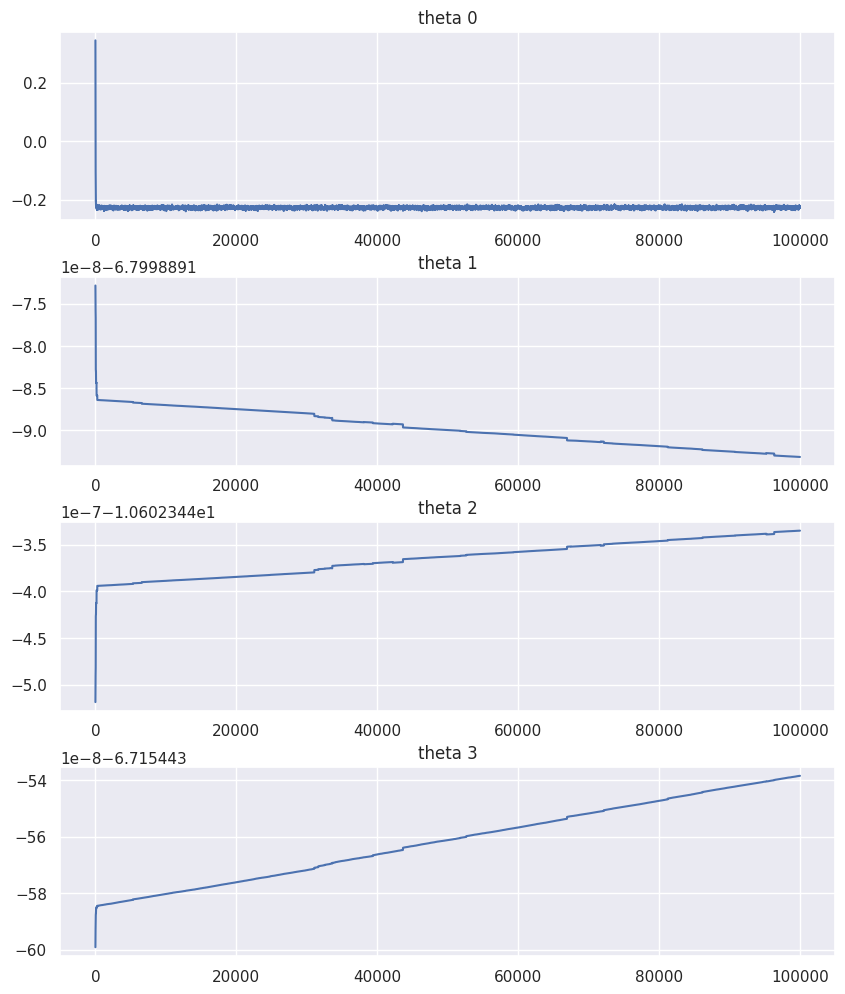

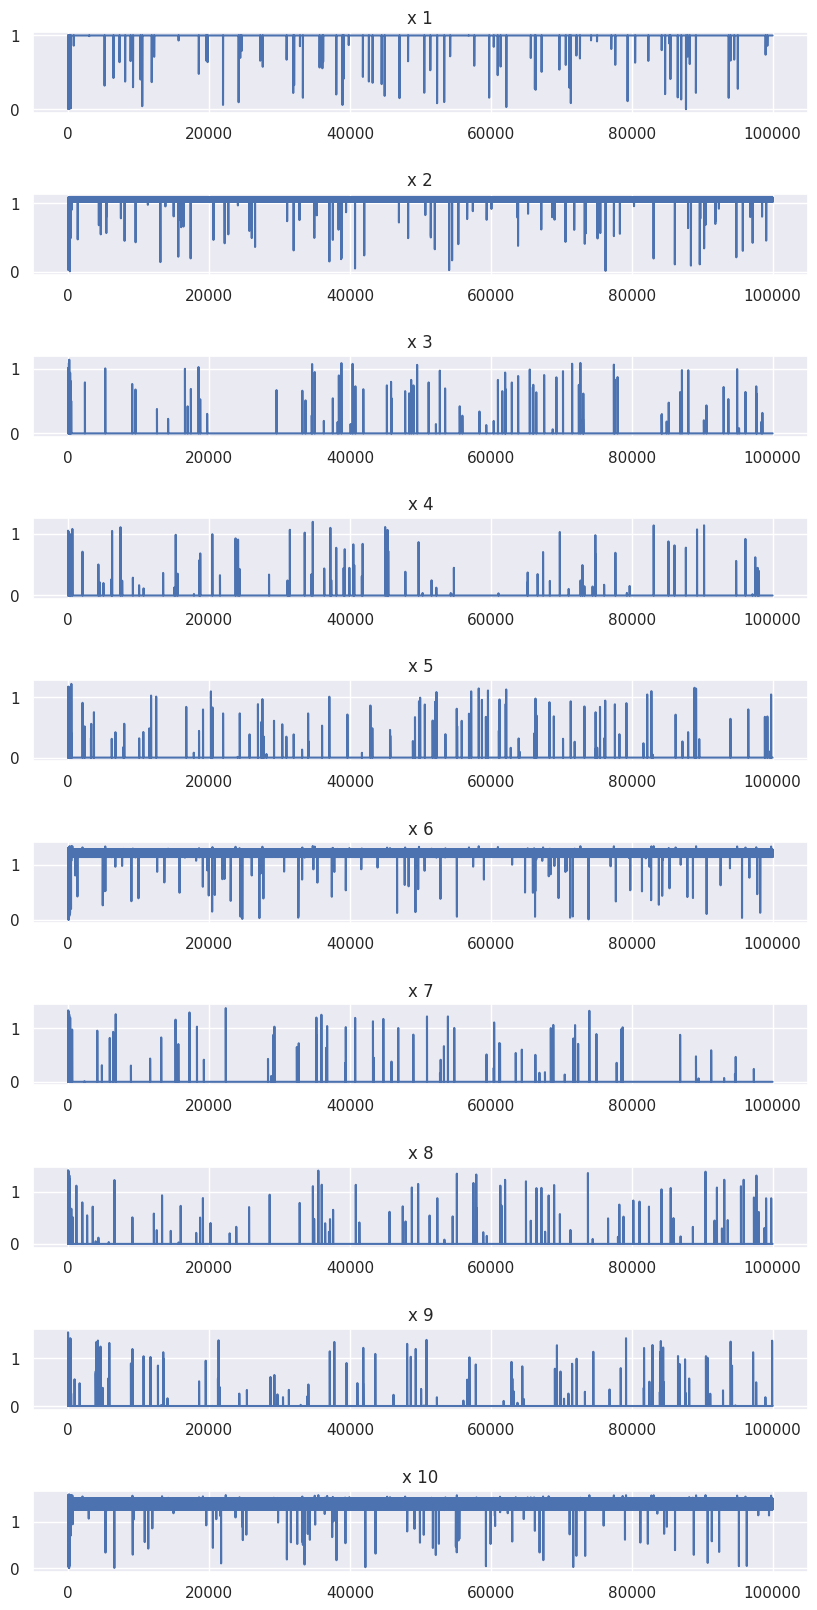

In [17]:
plotTemp(temp4,4,T)

$$
Q_{t}^5(W_{t},x_{t}|\vec{\theta})=\theta_{0,t}e^{(\theta_{1,t}W_{t}+\theta_{2,t}x_{t})}+\theta_{3,t}e^{(\theta_{4,t}W_{t}+\theta_{5,t}x_{t})}
$$

In [18]:
thetaexp5, temp5 = trainSARSA(W_0,T,alpha,gamma,a,A,B,r,p,n,Qexp5,Gradient_qexp5,6,"Bernoulli",decay = True)

  0%|          | 0/100000 [00:00<?, ?it/s]

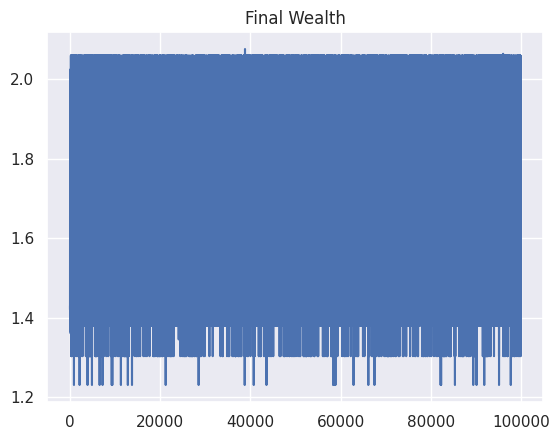

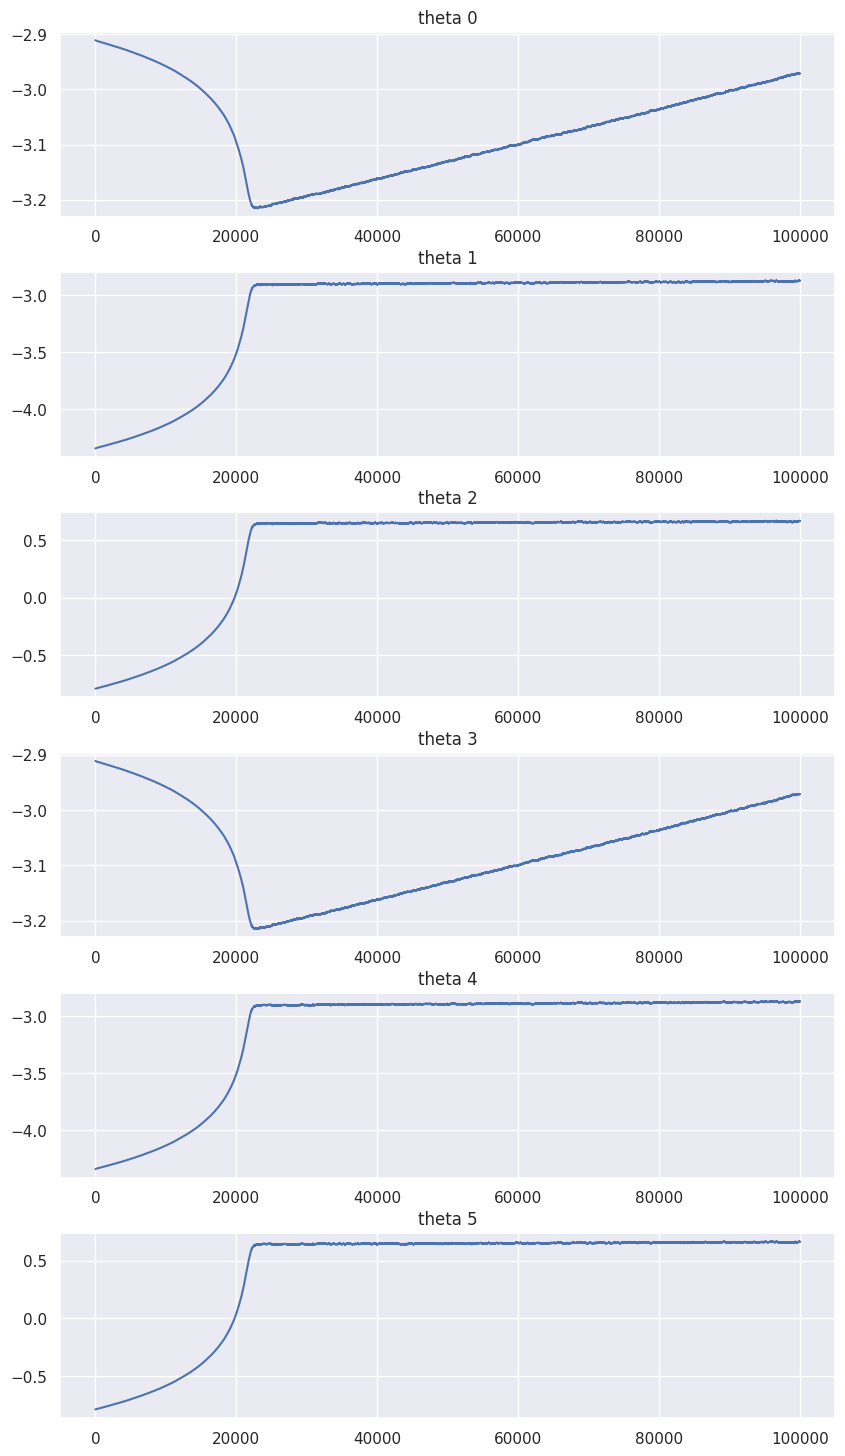

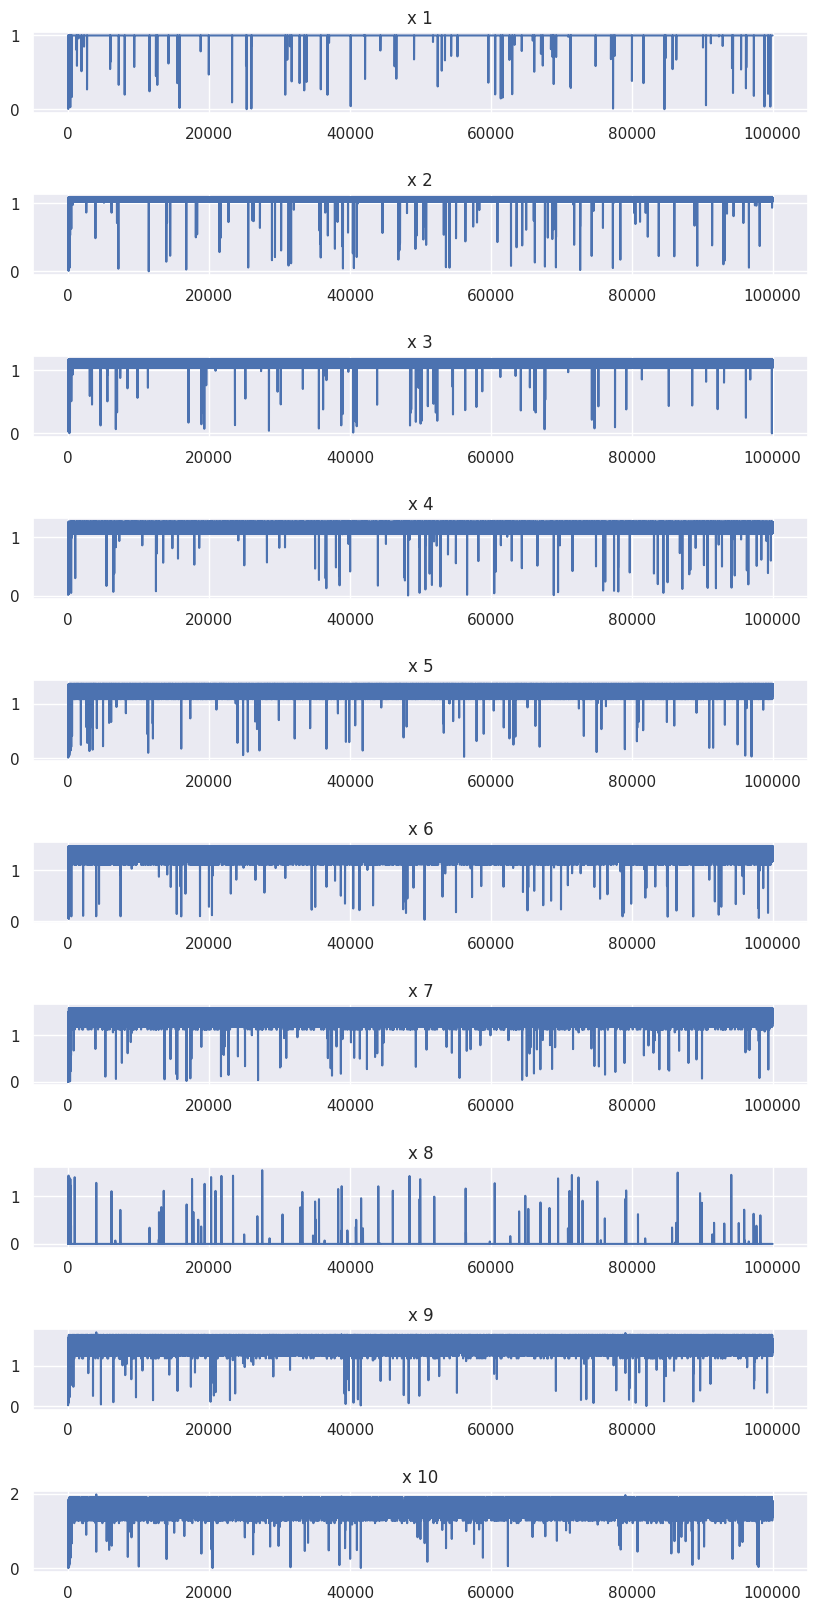

In [19]:
plotTemp(temp5,6,T)

$$
Q_{t}^{6}(W_{t},x_{t}|\vec{\theta})=\theta_{0,t}+\theta_{1,t}e^{(\theta_{2,t}W_{t}+\theta_{3,t}x_{t})}+\theta_{4,t}e^{(\theta_{5,t}W_{t}+\theta_{6,t}x_{t})}
$$

In [20]:
thetaexp6, temp6 = trainSARSA(W_0,T,alpha,gamma,a,A,B,r,p,n,Qexp6,Gradient_qexp6,7,"Bernoulli",decay = True)

  0%|          | 0/100000 [00:00<?, ?it/s]

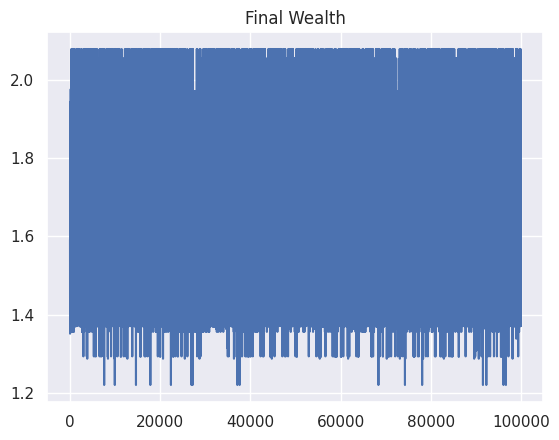

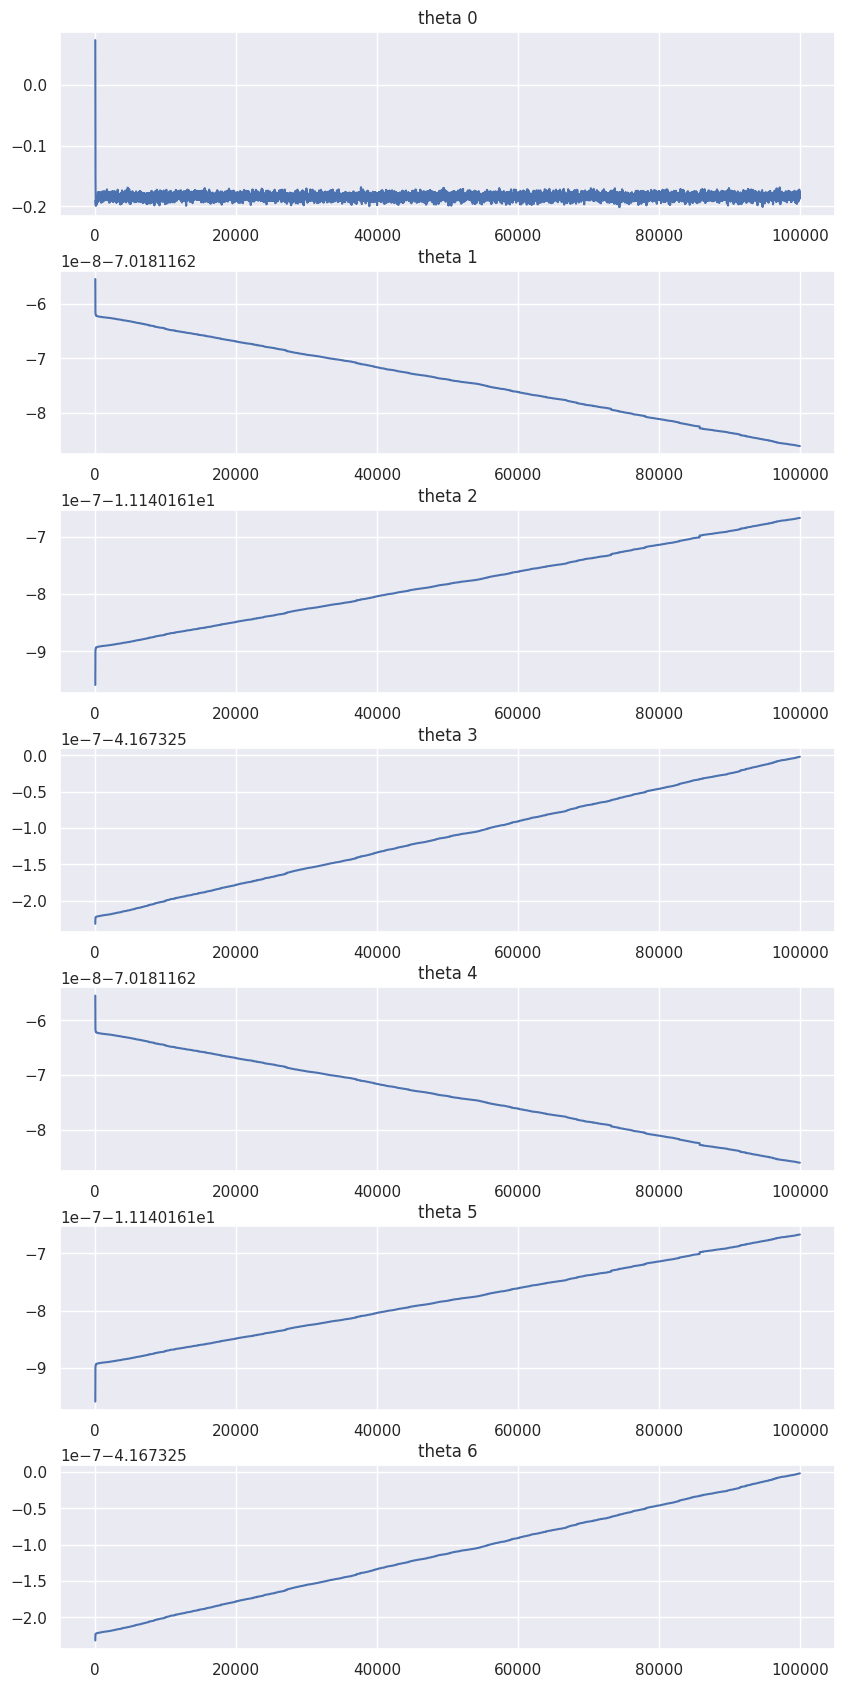

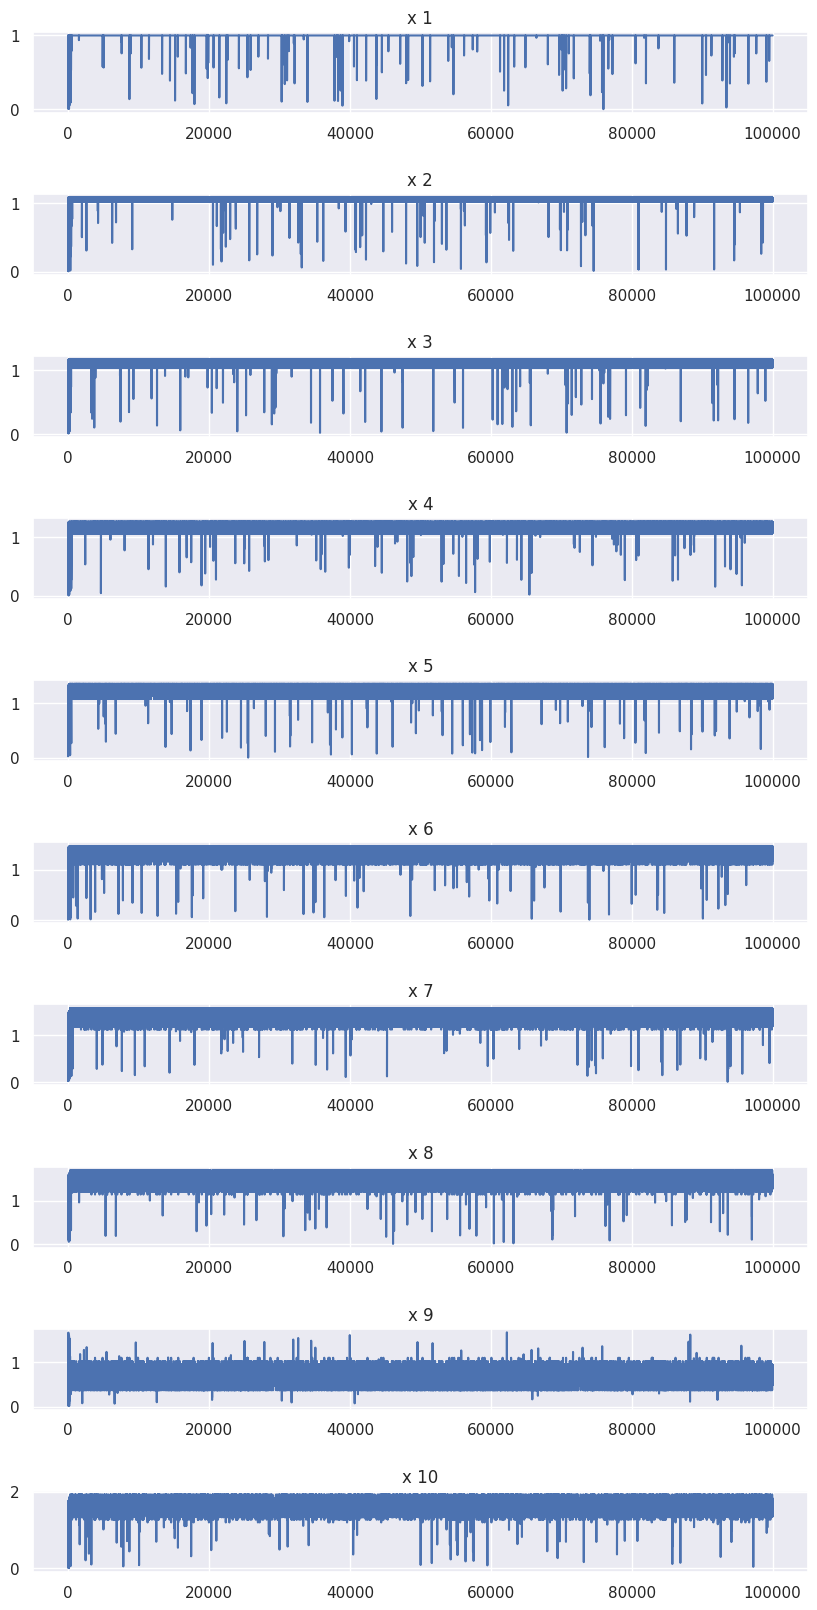

In [21]:
plotTemp(temp6,7,T)

Although the functional approximation form $Q^5_t$ is the closest to the analytical solution, the trained allocation sadly differs alot form the analytical solution